In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [44]:
data = pd.read_csv('day.csv')
data.head()


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


By looking at the column name, we should rename the columns for better readability. Like yr -> year, mnth -> month, hum -> humidity, cnt -> count.

In [45]:
data.rename(columns={'yr':'year', 'mnth':'month', 'hum':'humidity', 'cnt': 'count'}, inplace=True)

Now we should remove unwanted columns, from the data dictionary we can conclude the followin
1. Column 'instant' is index of the record.
2. Column 'dteday' is date of the record, as this is covered by columns 'month' and 'year'
3. Columns 'casual' and 'registered' breakup of column 'count' and not required for our analysis

In [46]:
data.drop(['instant','dteday','casual','registered'],axis=1,inplace=True)

The categorical columns are represented as numeric value. We should update those folumns with a meaningful values.
- Column 'season' with spring, summer, fall and winter.
- Column 'month' with jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec.
- Column 'weekday' with sun, mon, tue, wed, thu, fri, sat
- Column 'weathersit' with 'clear', 'cloudy', 'light_snow', 'heavy_rain'

In [47]:
data.season = data.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
data.month = data.month.map({1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun', 7:'jul',8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'})
data.weekday = data.weekday.map({0:'sun', 1:'mon', 2:'tue', 3:'wed', 4:'thu', 5:'fri', 6:'sat'})
data.weathersit = data.weathersit.map({1:'clear', 2:'mist', 3:'light_snow', 4:'heavy_rain'})

As mentioned in the project description, we need to convert some of the numeric variables that represent categories (season, year, month, holiday, weekday, workingday, and weathersit) into categorical variables. Let's do that next.

In [48]:
categorical_columns = ['season', 'year', 'month', 'holiday', 'weekday', 'workingday', 'weathersit']
data[categorical_columns] = data[categorical_columns].astype('category')
data.head()


,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,count
0,spring,0,jan,0,sat,0,mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,sun,0,mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,mon,1,clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,tue,1,clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,wed,1,clear,9.305237,11.46350,43.6957,12.522300,1600


Now that we've converted the necessary columns to categorical data, we can perform an exploratory data analysis (EDA) to gain a better understanding of the data. This process involves examining the distributions of the variables and their relationships with the target variable ('count').

Since the dataset is quite large, it's important to first check for missing values. Afterward, we can look at the distributions of the numerical and categorical variables. Finally, we can use correlation analysis and visualization to understand the relationships between the features and the target variable. Let's start with checking for missing values.

In [49]:
data.isnull().sum()

season        0
year          0
month         0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
dtype: int64

The dataset doesn't contain any missing values, which is great because it simplifies our analysis process

Let's conduct some descriptive statistics to understand the central tendency, dispersion, and shape of the dataset's distribution. We'll separate this process for numerical and categorical features for a more detailed understanding.

In [50]:
numerical_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'count']
data[numerical_columns].describe()

,temp,atemp,humidity,windspeed,count
count,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,4508.006849
std,7.506729,8.150308,14.237589,5.195841,1936.011647
min,2.424346,3.953480,0.000000,1.500244,22.000000
25%,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,26.880615,30.445775,72.989575,15.625589,5966.000000
max,35.328347,42.044800,97.250000,34.000021,8714.000000


The numerical variables have the following characteristics:

- temp: The average temperature is approximately 20.32 degrees Celsius with a standard deviation of 7.51. The minimum temperature is 2.42 degrees, and the maximum is 35.33 degrees.
- atemp: The average "feels like" temperature is about 23.73 degrees Celsius, with a standard deviation of 8.15. The minimum "feels like" temperature is 3.95 degrees, and the maximum is 42.04 degrees.
- humidity: The average humidity is around 62.76 with a standard deviation of 14.24. The minimum humidity is 0, and the maximum is 97.25.
windspeed: The average wind speed is around 12.76 with a standard deviation of 5.20. The minimum wind speed is 1.50, and the maximum is 34.00.
- count: The average total count of bike rentals (our target variable) is around 4508.01 with a standard deviation of 1936.01. The minimum count of bike rentals is 22, and the maximum is 8714.

Let's look at the distribution of our categorical variables.

In [51]:
data[categorical_columns].describe()

,season,year,month,holiday,weekday,workingday,weathersit
count,730,730,730,730,730,730,730
unique,4,2,12,2,7,2,3
top,fall,0,aug,0,mon,1,clear
freq,188,365,62,709,105,499,463


The categorical variables have the following characteristics:

- season: This variable has four unique values representing the four seasons. The most frequent season is 3 (fall), which occurs 188 times in the dataset.
- year: This variable indicates the year and has two unique values: 0 (2018) and 1 (2019). The year 2018 appears most frequently, with 365 occurrences.
- month: This variable represents the month and has 12 unique values. The most frequent month is January (1), with 62 occurrences.
- holiday: This variable indicates whether the day is a holiday. It has two unique values: 0 (not a holiday) and 1 (holiday). Non-holidays are more frequent, with 709 occurrences.
- weekday: This variable represents the day of the week and has seven unique values. The most frequent day is Sunday (0), with 105 occurrences.
- workingday: This variable indicates whether the day is a working day. It has two unique values: 0 (not a working day) and 1 (working day). Working days are more frequent, with 499 occurrences.
- weathersit: This variable represents the weather situation and has three unique values: 1 (clear), 2 (misty), and 3 (light rain/snow). Clear weather is the most frequent, with 463 occurrences.

 Let's examine the correlations between the numerical variables and the target variable 'count'. This will provide a preliminary understanding of the relationships between the variables.

In [52]:
data[numerical_columns].corr()

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.991696,0.128565,-0.158186,0.627044
atemp,0.991696,1.000000,0.141512,-0.183876,0.630685
humidity,0.128565,0.141512,1.000000,-0.248506,-0.098543
windspeed,-0.158186,-0.183876,-0.248506,1.000000,-0.235132
count,0.627044,0.630685,-0.098543,-0.235132,1.000000


From the correlation matrix, we can see that:

- Both temp and atemp show a strong positive correlation with the target variable count. This suggests that as the temperature increases, the demand for bikes also increases.
- humidity has a slight negative correlation with cnt, suggesting that higher humidity may lead to a decrease in bike demand.
- windspeed has a moderate negative correlation with cnt, suggesting that higher wind speeds may reduce the demand for bikes.

Let's visualize these correlations to better understand these relationships. We will use scatter plots for temp, atemp, humidity, windspeed vs count to observe their relationships. We also want to look at the box plots for the categorical variables vs count to see if there's a significant difference in count across different categories.

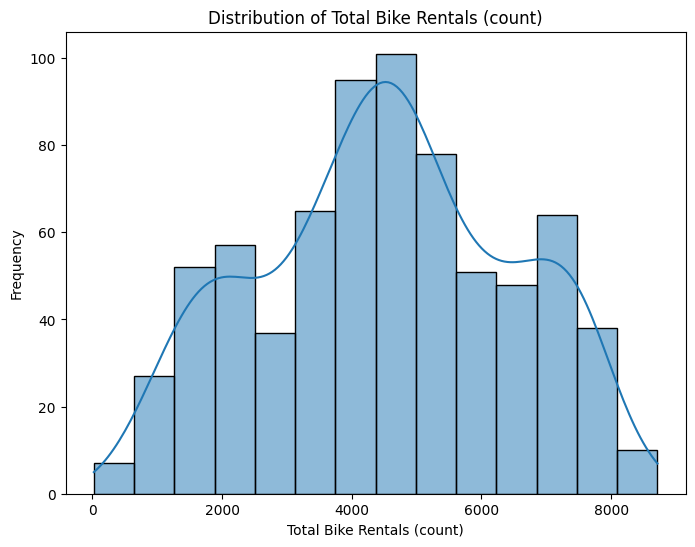

In [53]:
plt.figure(figsize=(8, 6))
sns.histplot(data['count'], kde=True)
plt.title('Distribution of Total Bike Rentals (count)')
plt.xlabel('Total Bike Rentals (count)')
plt.ylabel('Frequency')
plt.show()

The distribution of the target variable 'count' (total bike rentals) appears to be somewhat normally distributed, with a slight skew to the right. This suggests that on most days, the number of total bike rentals is around 4500-5000, but there are some days with exceptionally high numbers of rentals.

Let's visualize the relationships between the numerical variables and the target variable 'cnt'. We'll use scatter plots for this purpose.

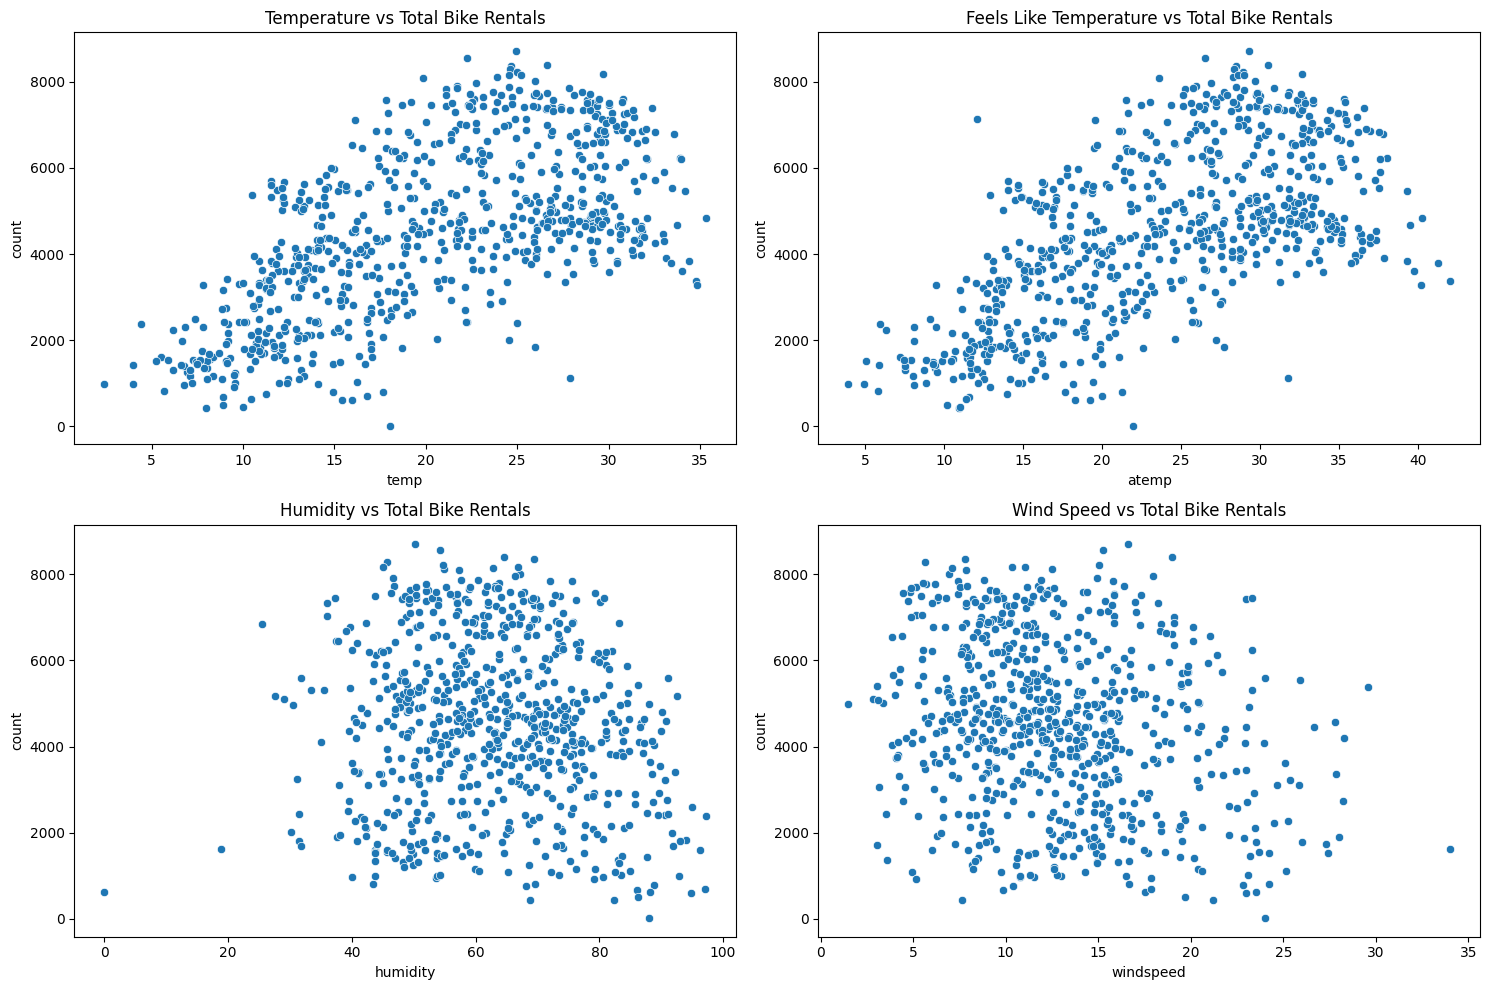

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(ax=axes[0, 0], data=data, x='temp', y='count')
axes[0, 0].set_title('Temperature vs Total Bike Rentals')

sns.scatterplot(ax=axes[0, 1], data=data, x='atemp', y='count')
axes[0, 1].set_title('Feels Like Temperature vs Total Bike Rentals')

sns.scatterplot(ax=axes[1, 0], data=data, x='humidity', y='count')
axes[1, 0].set_title('Humidity vs Total Bike Rentals')

sns.scatterplot(ax=axes[1, 1], data=data, x='windspeed', y='count')
axes[1, 1].set_title('Wind Speed vs Total Bike Rentals')

plt.tight_layout()
plt.show()


The scatter plots provide the following insights:

- Temperature vs Total Bike Rentals: There seems to be a positive correlation between temperature and total bike rentals, implying that the demand for bikes increases as the temperature rises.
- Feels Like Temperature vs Total Bike Rentals: Similar to the actual temperature, the 'feels like' temperature also has a positive correlation with the total bike rentals.
- Humidity vs Total Bike Rentals: There doesn't appear to be a clear relationship between humidity and total bike rentals. There are points scattered - across the plot, suggesting that humidity might not be a significant factor in predicting bike demand.
Wind Speed vs Total Bike Rentals: Higher wind speeds seem to correspond to lower total bike rentals, indicating a negative correlation.

Let's visualize the relationships between the categorical variables and the target variable 'count'. We'll use box plots for this purpose.

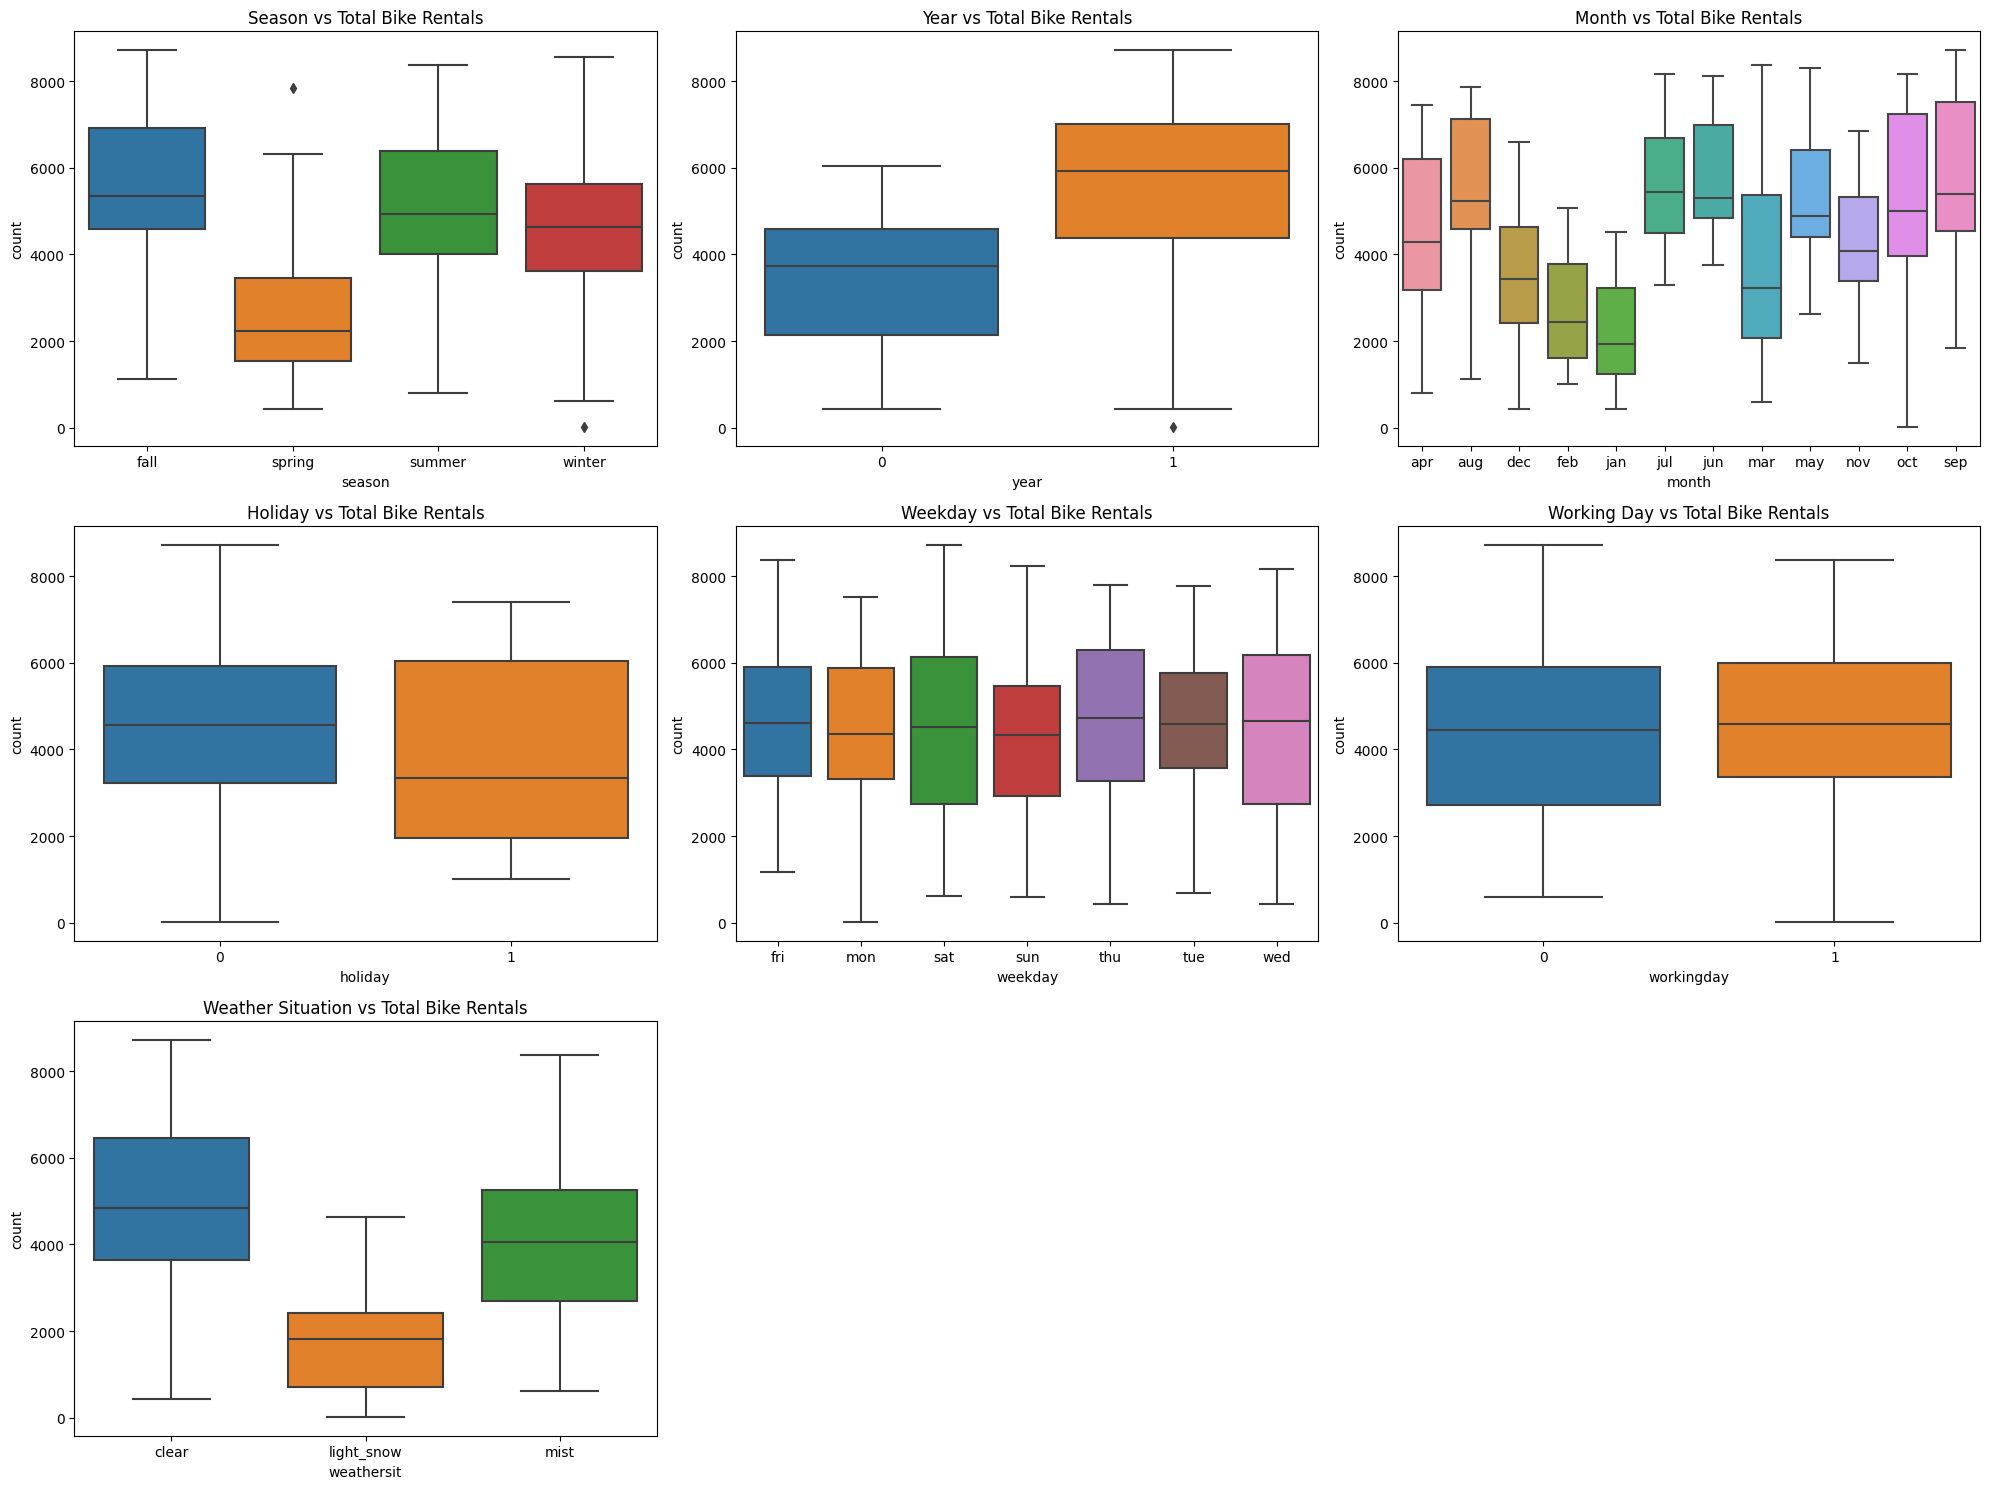

In [55]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

sns.boxplot(ax=axes[0, 0], data=data, x='season', y='count')
axes[0, 0].set_title('Season vs Total Bike Rentals')

sns.boxplot(ax=axes[0, 1], data=data, x='year', y='count')
axes[0, 1].set_title('Year vs Total Bike Rentals')

sns.boxplot(ax=axes[0, 2], data=data, x='month', y='count')
axes[0, 2].set_title('Month vs Total Bike Rentals')

sns.boxplot(ax=axes[1, 0], data=data, x='holiday', y='count')
axes[1, 0].set_title('Holiday vs Total Bike Rentals')

sns.boxplot(ax=axes[1, 1], data=data, x='weekday', y='count')
axes[1, 1].set_title('Weekday vs Total Bike Rentals')

sns.boxplot(ax=axes[1, 2], data=data, x='workingday', y='count')
axes[1, 2].set_title('Working Day vs Total Bike Rentals')

sns.boxplot(ax=axes[2, 0], data=data, x='weathersit', y='count')
axes[2, 0].set_title('Weather Situation vs Total Bike Rentals')

fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])

plt.tight_layout()
plt.show()


The box plots provide the following insights:

- Season vs Total Bike Rentals: The demand for bikes seems to be highest in the fall (season 3) and lowest in the spring (season 1). This could be due to weather conditions being most favorable for biking in the fall.
- Year vs Total Bike Rentals: There is an apparent increase in the total bike rentals from 2018 to 2019, indicating that the demand for bikes has increased over time.
- Month vs Total Bike Rentals: The demand for bikes seems to peak around the middle of the year, particularly in the months of May to October. This could be due to warmer weather during these months.
- Holiday vs Total Bike Rentals: Bike rentals seem to be slightly lower on holidays compared to non-holidays. This could be because people are more likely to stay home or use other modes of transportation during holidays.
- Weekday vs Total Bike Rentals: The day of the week doesn't seem to have a significant impact on the total bike rentals.
- Working Day vs Total Bike Rentals: There isn't a significant difference in bike rentals between working days and non-working days. This suggests that the demand for bikes is quite steady throughout the week.
- Weather Situation vs Total Bike Rentals: As expected, the demand for bikes is highest on clear days and lowest on days with light rain or snow. This shows that weather conditions significantly impact bike demand.

Let's proceed with data preparation for Model Building
- Create dummy variables for categorical variables
- 